# Pauli twirling a noise channel
This notebook implements a Pauli twirl of an arbitrary noise channel and a method to learn the fidelities through cycle benchmarking. Then, readout twirling is incorporated and the procedure is tested for several pauli operators on a noisy simulator. Lastly, the optimal estimation procedure detailed in [1] is used to estimate pauli fidelities

Resources that I used:
1. Probabilistic error cancellation with sparse Pauli-Lindblad models on noisy quantum processors
2. Model-free readout-error mitigation for quantum expectation values
3. Characterizing large-scale quantum computers via cycle benchmarking
4. Experimental Pauli-frame randomization on a superconducting qubit
5. Efficient Estimation of Pauli channels

In [30]:
from qiskit import QuantumCircuit, Aer, transpile, IBMQ
from qiskit.quantum_info import Pauli
from random import choice, random
from qiskit.providers.aer.noise import depolarizing_error, NoiseModel, amplitude_damping_error
from qiskit.test.mock import FakeQuitoV2
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from itertools import product, cycle
from copy import deepcopy
import pickle

## Proof of pauli twirl
Pauli twirling consists of uniformly sampling an operators from $\mathcal P^n$ and inserting it before and after application of noise. The noiseless twirled circuit is logically equivalent to the origin circuit, but in the presence of noise it has the effect of diagonlizing the errors in the pauli basis.

Here is a proof of the noise twirling:

Consider the Kraus map of the noise
$$
\Lambda(\rho) = \sum_k M_k \rho M_k^\dagger
$$
The noise twirl acts on a channel by conjugating the Kraus operators:
$$
\Lambda^{\mathcal{P}^n}(\rho) = \frac{1}{4^n}\sum_{i,k} P_iM_kP_i(\rho)P_iM_k^\dagger P_i
$$
Each kraus operator can be decomposed in the pauli basis as 
$$
M_k = \sum_{j}c_{kj}P_j
$$
Then the channel becomes
$$
\begin{align*}
\Lambda^{\mathcal{P}^n}(\rho) &= \frac{1}{4^n}\sum_{i,k} P_iM_kP_i(\rho)P_iM_kP_i\\
&=\frac{1}{4^n}\sum_{i,j,k,l} c_jc_l^\ast P_iP_jP_i(\rho)P_iP_lP_i\\
\end{align*}
$$
Define a function $\zeta(P_a, P_b)$ to measure the commutativity of $P_a$ and $P_b$ as $P_aP_b = \zeta(P_a,P_b)$. It can be seen that
$$
P_a(P_bP_c) = \zeta(P_a,P_b)P_bP_a = \zeta(P_a,P_b)\zeta(P_a,P_c)(P_bP_c)P_a
$$
and so $\zeta(P_a,P_b)\zeta(P_a,P_c) = \zeta(P_a,P_bP_c)$. With this problem, the channel can be simplified:
$$
\begin{align*}
\frac{1}{4^n}\sum_{i,j,k,l} c_{kj}c_{kl}^\ast P_iP_jP_i(\rho)P_iP_lP_i &= \frac{1}{4^n}\sum_{i,j,k,l} c_{kj}c_{kl}^\ast\zeta(P_i,P_j)\zeta(P_i,P_l) P_jP_iP_i(\rho)P_lP_iP_i \\
&= \frac{1}{4^n}\sum_{i,j,k,l} c_{kj}c_{kl}^\ast\zeta(P_i,P_jP_l)P_j(\rho)P_l \\
&= \frac{1}{4^n}\sum_{i,j,k,l} c_{kj}c_{kl}^\ast P_j(\rho)P_l\sum_i \zeta(P_i, P_jP_l)
\end{align*}
$$
Let $P_m \equiv P_jP_l$. For fixed $m$, $\sum_{i \in \mathcal{P}^n} \zeta(P_i, P_m) = \delta_{m0}4^n$, which can be shown through induction on $n$. For the base case, the following table shows $\zeta(i,m)$ plotted with $P_i$ in the rows and $P_m$ in the columns:

| |I|X |Y |Z |
|-|-|--|--|--|
|I|1|1 |1 |1 |
|X|1|1 |-1|-1|
|Y|1|-1|1 |-1|
|Z|1|-1|-1| 1|

The sum of the first row is $4^1$, while the sum of subsequent rows is zero. This proves the base case. Now we may assume that
$$
\sum_{i \in \mathcal{P}^n} \zeta(P_i, P_m) = \delta_{0m}4^n
$$
for the inductive assumption. Let $P_j, P_r \in \mathcal{P}^{n+1}$. $P_j$ may be written as $P_{i}\otimes \sigma_{a}$ for some $i,a$, where $P_{a} \in \mathcal P^{n}$ and $\sigma_b \in \mathcal P^1$, and similarly $P_r = P_m \otimes \sigma_b$ for some fixed $m,c$. We observe that
$$
\begin{align*}
(P_i \otimes \sigma_a)(P_m \otimes \sigma_b) = P_iP_m \otimes \sigma_a\sigma_b = \zeta(P_i,P_m)\zeta(\sigma_a, \sigma_b)(P_m \otimes \sigma_b)(P_i \otimes \sigma_a)
\end{align*}
$$
and so $\zeta(P_j,P_r) = \zeta(P_i \otimes \sigma_a, P_m \otimes \sigma_b) = \zeta(P_i, \sigma_a)\zeta(P_m, \sigma_b)$. With this we find that
$$
\begin{align*}
\sum_{j \in \mathcal{P}^{n+1}} \zeta(P_j, P_r) &= \sum_{i \in \mathcal{P}^{n}, a \in \mathcal{P}} \zeta(P_j, P_r)\\
 &= \sum_{i \in \mathcal{P}^{n}, a \in \mathcal{P}} \zeta(P_i, P_m)\zeta(\sigma_a, \sigma_b)\\
 &= \left(\sum_{i \in \mathcal{P}^{n}} \zeta(P_i, P_m)\right)\left(\sum_{a\in \mathcal{P}}\zeta(\sigma_a, \sigma_b)\right)\\
 &= \delta_{m0}\delta_{b0}\\
 &= \delta_{r0}
 \end{align*}
$$
This completes the argument. Carrying on from before, this fact can be used to simplify the form of the channel further:
$$
\begin{align*}
\frac{1}{4^n}\sum_{i,j,k,l} c_{kj}c_{kl}^\ast P_j(\rho)P_l\sum_i \zeta(P_i, P_jP_l) &= \sum_{i,j,k,l} c_{kj}c_{kl}^\ast P_j(\rho)P_l\delta_{jl} \\
 &= \sum_{j,k} |c_{kj}|^2 P_j(\rho)P_j \\
 &= \sum_{j} \left(\sum_{k}|c_{kj}|^2\right) P_j(\rho)P_j \\
 &= \sum_{j} \alpha_j P_j(\rho)P_j \\
\end{align*}
$$
Where $\alpha_j > 0$. This shows that the twirled noise channel has the form of a pauli channel. By sampling from the distribution and averaging instead of computing the sum over $4^n$ terms directly, the estimator converges to the twirled channel
$$
\mathbb{E}_i[P_i\Lambda(P_i \rho P_i)P_i] = \Lambda^{\mathcal{P}^n} = \sum_{j}\alpha_jP_j\rho P_j
$$

In [31]:
#This method returns a circuit replicating fig. S1 in the sparse model paper.
#adjacent layers are composed together so that there are k repetitions of the noise
def twirled_circuit(n : int, l : int) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    ops = [Pauli('I')]*n
    #iterate over the layers
    for j in range(l-1):
        #iterate over the qubits
        for i in range(n):
            #choose a random single-qubit Pauli
            p = Pauli(choice(['I','X','Y','Z']))
            #chain the layers together so that the last half of the previous
            #cycle is combined with the first half of the next
            op = ops[i].compose(p)
            qc.append(Pauli([op.z],[op.x]), [i]) #this trick gets rid of the phase
            qc.barrier()
            ops[i] = p
    #fill in the last layer so that the logical circuit is the identity
    for i in range(n):
        op = ops[i] 
        qc.append(Pauli([op.z],[op.x]), [i])
    return qc

#This implements the readout twirling procedure to diagonalize the readout errors
# in the readout basis.
def twirled_readout(n):
    qc = QuantumCircuit(n)
    #this string is returned to get the adjusted result of running the circuit
    binstr = ""
    for i in range(n):
        r = random()
        #sample unifromly from {X,I}
        if r < .5:
            qc.x(i)
            #record the bit flips
            binstr += '1'
        else:
            qc.id(i)
            binstr += '0'
    return(qc, binstr)

## Test error model
For the test model, I started with a depolarizing channel as a control. I also used an amplitude damping channel for the fact that it is not already diagonal in the pauli basis.

In [32]:
p = .01
depol = depolarizing_error(p, 1)
damping = amplitude_damping_error(p, .4)
amplitude_damping = NoiseModel()
depolarizing = NoiseModel()
depolarizing.add_all_qubit_quantum_error(depol, ['id','u1','u2','u3'])
amplitude_damping.add_all_qubit_quantum_error(damping, ['id','u1','u2','u3'])

In [33]:
# Displays a nice progress bar
def progressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

#compute the binary sum of two bitstrings
def oplus(binstr1, binstr2):
    result = ""
    for i,b in enumerate(binstr2):
        if binstr1[i] == '1':
            result += {'0':'1','1':'0'}[b]
        else:
            result += b
    return result

def dot(binstr1, binstr2):
    return np.sum([{('1','1'):1}.get(pair, 0) for pair in zip(binstr1, binstr2)])

## Optimal number of shots
My circuits were running really slowly, but I noticed that there is a trade-off between two sources of noise, the shot noise and the deviation from the pauli-twirl. Since there are only 16 pauis in the group, sampling 1000 times from the group is a bit overkill, but the shot noise is still reasonably high at 1000 shots. I found that the accuracy and the speed were greatly improved by sampling a smaller number of circuits and then running a greater number of shots on each one. The van den Berg paper mentions that the number of samples taken was 100 and the number of shots on each sample was 256 for benchmarking the CNOT layers.

In [34]:
n = 2 #dimension of the system
scale_factor = 2 #how many shots to run vs the size of the ditribution
samples = int(2**(2*n)*scale_factor*2**n) #samples to take
shots = 100 #shots of each circuit
lengths = [2,4,8,16,32,64,128] #lengths of cycle benchmarking
results = np.zeros([4, len(lengths)]) #store frequency of each outcome for each length
backend = Aer.get_backend('qasm_simulator')
for m,l in enumerate(lengths):
    result = 0
    for i in range(samples):
        qc = QuantumCircuit(2)
        #add the twirled layers
        tw = twirled_circuit(2,l)
        qc = qc.compose(tw)

        #add the readout layer
        ro, binstr = twirled_readout(n)
        qc = qc.compose(ro)
        qc.measure_all()

        #transpile the circuits
        circ = transpile(qc, backend, optimization_level=0)
        #get counts
        counts = backend.run(circ, noise_model = amplitude_damping, shots = shots).result().get_counts()
        #compute the expectation value of ZZ, adjusted for the readout twirling
        result += (counts.get(oplus('00', binstr),0) - counts.get(oplus('01',binstr), 0) - counts.get(oplus('10', binstr),0)+counts.get(oplus('11', binstr),0))
        #count resultts
        for k in range(4):
            results[k][m] += counts.get(oplus(bin(k)[2:].zfill(2)[::-1], binstr), 0)/(shots*samples)
        progressBar(m*samples+i, len(lengths)*samples)

## Measuring the fidelity
Last week, I was asking how to avoid having to prepare all eigenstates of the Pauli operator, which would be inefficient in $n$. The sparse model paper suggests that preparing $\ket{0}\bra{0}$ is sufficient. I found a proof for why these are equivalent, specifically
$$
\frac{1}{2^n}\operatorname{Tr}[P_a\Lambda(P_a)] = \operatorname{Tr}[P_a\Lambda(\ket{+}\bra{+})]
$$
Where $\ket{+}$ is any +1 eigenstate of $P_a$. Working in the $Z$ basis, consider $P_{z(a)} = Z[a]$, where $Z[a]$ is defined $Z[a] = \bigotimes_i Z^{a_i}$. The operator $Z[a]$ can be diagonalized via
$$
Z[a] = \sum_{b \in \{0,1\}^{\otimes n}}(-1)^{b\cdot a}\ket{b}\bra{b}
$$
Using this, observing that $\ket{b} = X[b]\ket{0}$, and leveraging the fact that Pauli channels commute with each other,
$$
\begin{align*}
\frac{1}{2^n}\operatorname{Tr}[Z[a]\Lambda(Z[a])] &= \frac{1}{2^n}\sum_{b \in \{0,1\}^{\otimes n}}(-1)^{b\cdot a}\operatorname{Tr}[Z[a]\Lambda(\ket{b}\bra{b})]\\
&=\frac{1}{2^n}\sum_{b \in \{0,1\}^{\otimes n}}(-1)^{b\cdot a}\operatorname{Tr}[Z[a]\Lambda(X[b]\ket{0}\bra{0}X[b])]\\
&=\frac{1}{2^n}\sum_{b \in \{0,1\}^{\otimes n}}(-1)^{b\cdot a}\operatorname{Tr}[Z[a](\mathcal{X}[b] \circ \Lambda)(\ket{0}\bra{0})]\\
\end{align*}
$$
Using the form of $\Lambda$ as a pauli channel, we have
$$
\begin{align*}
\Lambda(\ket{0}\bra{0}) &= \sum_{i}c_iP_i\ket{0}\bra{0}P_i\\
&= \sum_{j,k \in \{0,1\}^{\otimes n}}c_{jk}X[j]Z[k]\ket{0}\bra{0}X[j]Z[k]\\
&= \sum_{j\in \{0,1\}^{\otimes n}} \alpha_{j}X[j]\ket{0}\bra{0}X[j]\\
&= \sum_{j\in \{0,1\}^{\otimes n}} \alpha_{j}\ket{j}\bra{j}\\
\end{align*}
$$
Putting this back into the expectation value,
$$
\begin{align*}
\frac{1}{2^n}\sum_{b \in \{0,1\}^{\otimes n}}(-1)^{b\cdot a}\operatorname{Tr}[Z[a](\mathcal{X}[b] \circ \Lambda)(\ket{0}\bra{0})] &= \frac{1}{2^n}\sum_{j,b \in \{0,1\}^{\otimes n}}\alpha_j(-1)^{b\cdot a}\operatorname{Tr}[Z[a]\mathcal{X}[b](\ket{j}\bra{j})]\\
&= \frac{1}{2^n}\sum_{j,b \in \{0,1\}^{\otimes n}}\alpha_j(-1)^{b\cdot a}\operatorname{Tr}[Z[a]\ket{j \oplus b}\bra{j \oplus b}]\\
\end{align*}
$$
The expectation value is given by the overlap in the computational basis, $\operatorname{Tr}[Z[a]\ket{b}\bra{b}] = (-1)^{a\cdot b}$, and so
$$
\begin{align*}
\frac{1}{2^n}\sum_{j,b \in \{0,1\}^{\otimes n}}\alpha_j(-1)^{b\cdot a}\operatorname{Tr}[Z[a]\ket{j \oplus b}\bra{j \oplus b}] &=  \frac{1}{2^n}\sum_{j,b \in \{0,1\}^{\otimes n}}\alpha_j(-1)^{b\cdot a}(-1)^{a\cdot(j\oplus b)} \\
 &= \sum_{j \in \{0,1\}^{\otimes n}}\alpha_j(-1)^{a\cdot j} \\
 &= \operatorname{Tr}[Z[a]\Lambda(\ket{0}\bra{0})] 
\end{align*}
$$

This shows that
$$
\frac{1}{2^n}\operatorname{Tr}[Z[a]\Lambda(Z[a])] = \operatorname{Tr}[Z[a]\Lambda(\bra{0}\ket{0})]
$$
Since measuring the fidelity of any pauli operator is identical up to a change in the preparation and measurement basis, this argument holds not just for $Z[a]$, but for every $P_a$

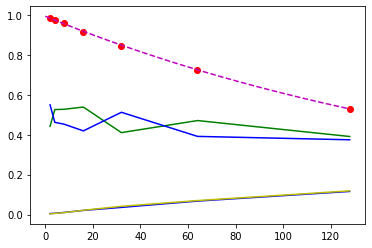

In [35]:
#under amplitude damping noise, all of the counts converge to a non-zero equilibrium, 
#but the expectation value does converge to zero

#measurement results in the computational basis
plt.plot(lengths, results[0],'g')
plt.plot(lengths, results[1],'b')
plt.plot(lengths, results[2],'y')
plt.plot(lengths, results[3], 'b')

#get the expectation value of ZZ
tot = [r0-r2-r1+r3 for (r0,r1,r2,r3) in zip(results[0], results[1], results[2], results[3])]

#fit to an exponential decay, where a represents SPAM errors
popt,pcov = curve_fit(lambda x,a,b: a*np.exp(-b*x), lengths, tot, p0=[.9, .01])


plt.plot(lengths, tot, 'ro')
xrange = np.linspace(0,np.max(lengths), 100)
plt.plot(xrange, [popt[0]*np.exp(-popt[1]*x) for x in xrange], 'm--')

In [36]:
#generate pauli measurement circuitry with corresponding metadata
def pauli_meas(pauli, lengths, samples, backend):
    info = []
    circs = []

    #iterate over lengths
    for m,l in enumerate(lengths):
        for i in range(samples):
            qc = QuantumCircuit(2)

            #switch to pauli basis
            for k,p in enumerate(pauli):
               match p:
                case 'X':
                    qc.h(k)
                case 'Y':
                    qc.h(k)
                    qc.s(k)
                case 'Z':
                    qc.id(k)
                    
            #add the twirled layers
            qc.barrier()
            tw = twirled_circuit(2,l)
            qc = qc.compose(tw)
            qc.barrier()

            #switch to measurement basis
            for k,p in enumerate(pauli):
               match p:
                case 'X':
                    qc.h(k)
                case 'Y':
                    qc.sdg(k)
                    qc.h(k)
                case 'Z':
                    qc.id(k)
            qc.barrier()

            #add the readout layer
            ro, binstr = twirled_readout(n)
            qc = qc.compose(ro)
            qc.measure_all()

            #transpile the circuits
            circ = transpile(qc, backend, optimization_level=0)
            info.append({'pauli': pauli, 'data':binstr, 'length':l})
            circs.append(circ)
            progressBar(m*samples+i, len(lengths)*samples)

    return (circs,info)

#turn the results and circuit metadata into expectation values and get exponential fit
def process_data(circuits_data, pauli_weight, samples, shots):
    #sort the data back into the lengths
    lengths = []
    expectations = []

    #iterate over the circuit data
    for circ in circuits_data:
        counts = circ['counts'] #circuit instance counts
        rostring = circ['data'] #readout twirl string
        #get the expectation value of Z[a] by summing P(b)(-1)**(a.b) over b
        expec = np.sum([counts[key]*(-1)**dot(oplus(key[::-1],rostring), pauli_weight) for key in counts.keys()]) 
        if not circ['length'] in lengths: #create a bin for lengths
            lengths.append(circ['length'])
            expectations.append(0)

        #collect the expectation values
        expectations[lengths.index(circ['length'])] += expec/(samples*shots)

    #get the exponential fit to the data
    popt, pcov = curve_fit(lambda x,a,b: a*np.exp(-b*x), lengths, expectations, p0=[.95, .01])
    return (popt[0], popt[1], lengths, expectations)

In [37]:
n=2 #number of qubitss
samples = 64 #number of random circuit instances per circuit depth
shots = 100 #shots to run per circuit
levels = [2,4,8,16, 32, 64, 128] #circuit depth levels
backend = FakeQuitoV2() #initialize fake backend
circs = []
data = []

for p in product('XYZ', repeat = n):
    circ, info = pauli_meas("".join(p), levels, samples, backend) #generate the transpiled circuits
    circs += circ #collect circuits in a batch
    data += info #store corresponding circuit metadata

In [38]:
result = backend.run(circs, shots = shots) #run the circuits

for i,count in enumerate(result.result().get_counts()):
    data[i]['counts'] = count #put the results in with the circuit metadata

In [39]:
#create a dictionary where the keys are Paulis
results = {"".join(p):[] for p in product("IXYZ", repeat = n)}
for datum in data:
    results[datum['pauli']].append(datum) #restructure the data into dictionary

In [40]:
coeffs = {}
#find fidelities for weight 1 paulis
for p in ['X','Y','Z']:
        #at least three simultaneous measurements can be found from one max-weight pauli measurement
        coeffs[p+'I'] = process_data(results[p+'X'], '10', samples, shots)
        coeffs['I'+ p] = process_data(results['X'+p], '01', samples, shots)

#find fidelities for weight two operators
for p in product(['X','Y','Z'], repeat = n):
        coeffs["".join(p)] = process_data(results["".join(p)], '11', samples, shots)

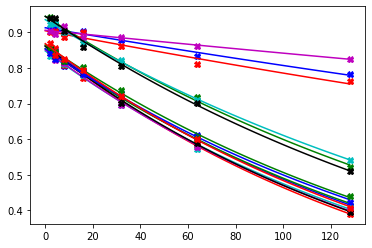

In [41]:
xrange = np.linspace(0, max(levels))
expfit = lambda x,a,b : a*np.exp(-b*x)
cycol = cycle('bgrcmk')

#plot exponential decays
for key in coeffs.keys():
    p_data = coeffs[key]
    c = next(cycol)
    plt.plot(levels, p_data[3],c+'X')
    plt.plot(xrange, [expfit(x, p_data[0], p_data[1]) for x in xrange], c)

<BarContainer object of 15 artists>

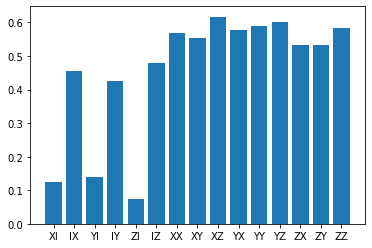

In [42]:
x = [range(4**n-1)]
bar = [100*(1-expfit(1,1, coeffs[key][1])) for key in coeffs.keys()]
plt.bar(range(len(bar)),bar,tick_label = list(coeffs.keys()))